In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sasviya.ml.tree import ForestClassifier
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Read Data

In [2]:
df_data = pd.read_csv('../data/diabetes_prediction_dataset.csv')
print('Number of Observations:', df_data.shape[0])
print('Number of Features Available:', df_data.shape[1]-1)
df_data.head()

Number of Observations: 100000
Number of Features Available: 8


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


##### Data Dictionary:
* Gender: Gender refers to the biological sex of the individual.
* Age: Age of the individual.
* Hypertension: Binary variable indicating whether the blood pressure in the arteries is persisently elevated.
* Heart Disease: Binary variable indicating whether individuals are suffering from heart diseases.
* Smoking History: 5 categories available (Not current, former, no info, current, never and ever).
* Body Mass Idex (BMI): Float measuring body fat based on weight and height.
* HbA1c_level: shows what your average blood sugar (glucose) level was over the past two to three months
* Blood Glucose Level: Float variable measuring the amount of glucose in the bloodstream at a given time.
* Diabetes: Binary target variable. 1=individual has diabetes, 0=individual does NOT have diabetes

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### Visualize it

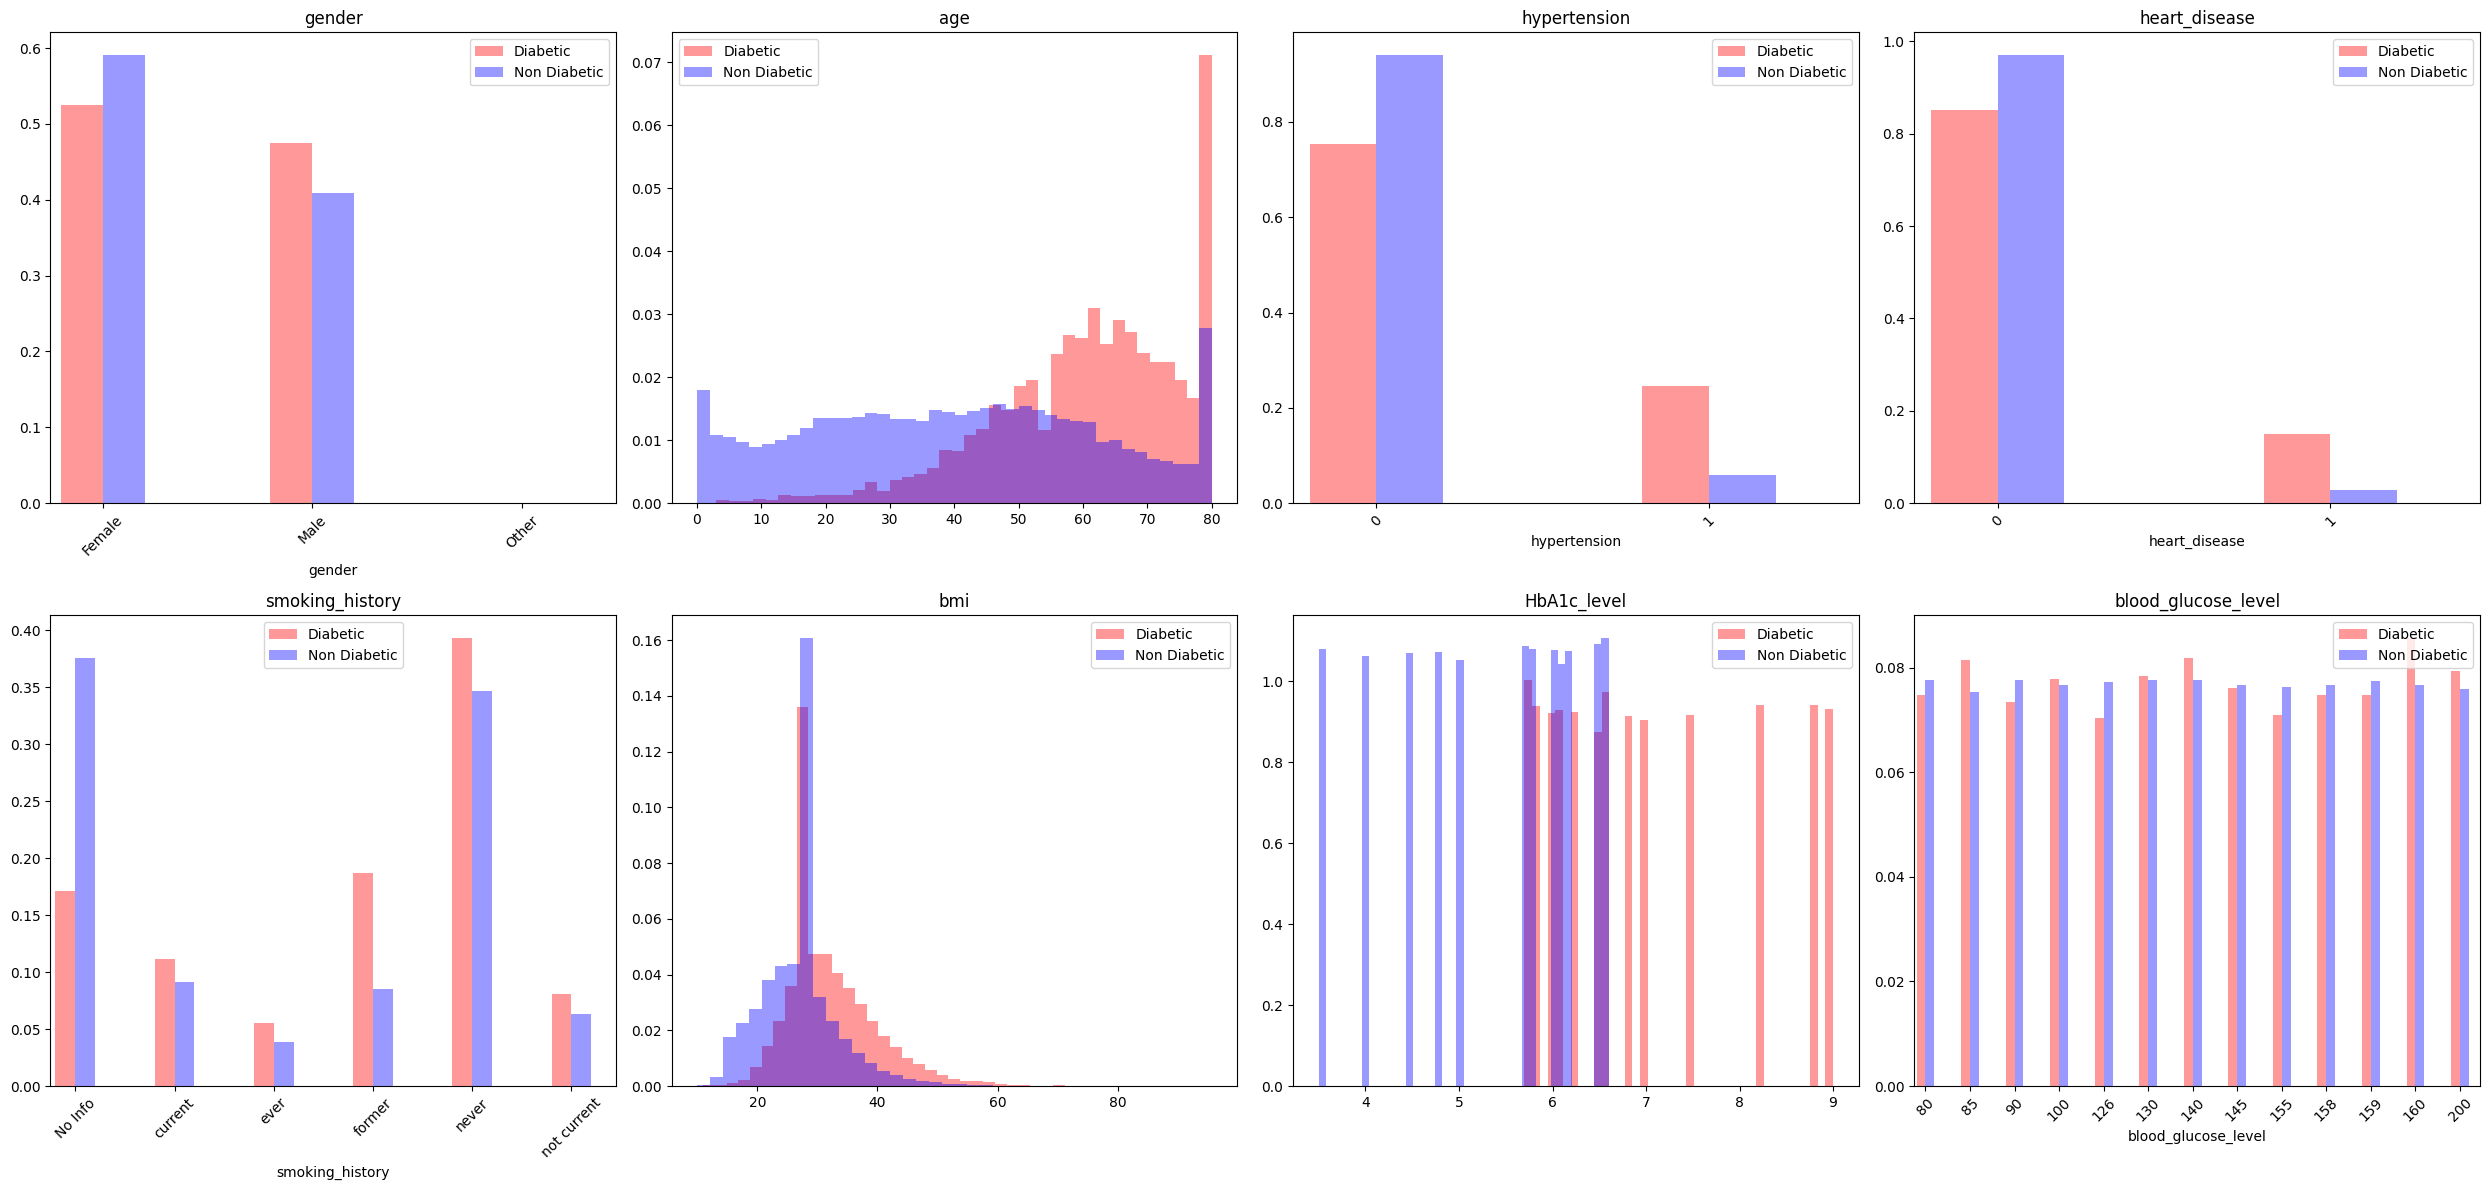

In [4]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(25, 12))
axs = axs.ravel()
columns = list(df_data.columns)
for i in range(len(axs)):
    ax=axs[i]
    if df_data[columns[i]].dtype =='float64':
        ax.hist(df_data[df_data['diabetes']==1][columns[i]], bins=40, color='red', alpha=0.4, density=True, label='Diabetic')
        ax.hist(df_data[df_data['diabetes']==0][columns[i]], bins=40, color='blue', alpha=0.4, density=True, label='Non Diabetic')
        ax.legend()
    else:
        df_data[df_data['diabetes']==1][columns[i]].value_counts(normalize=True).to_frame().\
            sort_values(by=columns[i]).plot(y='proportion',kind='bar', ax=ax, color='red', rot=45, label='Diabetic', alpha=0.4, position=1, width=0.2)
        df_data[df_data['diabetes']==0][columns[i]].value_counts(normalize=True).to_frame().\
            sort_values(by=columns[i]).plot(y='proportion',kind='bar', ax=ax, color='blue', rot=45, label='Non Diabetic', alpha=0.4, position=0, width=0.2)
        ax.legend()
    ax.set_title(columns[i])
plt.tight_layout()
plt.show()

In [5]:
correlation_cols = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
df_data[correlation_cols].corr().style.background_gradient(cmap=plt.cm.Blues).format(precision=2)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.00,0.25,0.23,0.34,0.10,0.11,0.26
hypertension,0.25,1.00,0.12,0.15,0.08,0.08,0.20
heart_disease,0.23,0.12,1.00,0.06,0.07,0.07,0.17
bmi,0.34,0.15,0.06,1.00,0.08,0.09,0.21
HbA1c_level,0.10,0.08,0.07,0.08,1.00,0.17,0.40
blood_glucose_level,0.11,0.08,0.07,0.09,0.17,1.00,0.42
diabetes,0.26,0.20,0.17,0.21,0.40,0.42,1.00


In [6]:
target = 'diabetes'
pd.concat([df_data[target].value_counts().to_frame(), df_data[target].value_counts(normalize=True).to_frame()], axis=1)

,count,proportion
diabetes,,
0,91500,0.915
1,8500,0.085


### Machine Learning Modelling

In [7]:
df_data['stratification_key']= df_data['hypertension'].astype(str) + '-' + df_data['heart_disease'].astype(str)+ '-' + df_data['smoking_history'].astype(str)+ '-' + df_data['diabetes'].astype(str)
train, test = train_test_split(df_data, train_size=0.7, stratify=df_data['stratification_key'])
valid, test =train_test_split(test, train_size=0.667, stratify=test['stratification_key'])
print('Train Size:', train.shape[0], '--- Diabetes Frequency:', f'{round(100*train.diabetes.sum()/train.shape[0],2)}%')
print('Valid Size:', valid.shape[0], '--- Diabetes Frequency:', f'{round(100*valid.diabetes.sum()/valid.shape[0],2)}%')
print('Test Size:', test.shape[0], '--- Diabetes Frequency:', f'{round(100*test.diabetes.sum()/test.shape[0],2)}%')

Train Size: 70000 --- Diabetes Frequency: 8.5%
Valid Size: 20010 --- Diabetes Frequency: 8.49%
Test Size: 9990 --- Diabetes Frequency: 8.51%


In [8]:
gender_encoder = LabelEncoder()
train['gender']=gender_encoder.fit_transform(train['gender'])
valid['gender']=gender_encoder.transform(valid['gender'])
test['gender']=gender_encoder.transform(test['gender'])

smoking_history_encoder = LabelEncoder()
train['smoking_history']=smoking_history_encoder.fit_transform(train['smoking_history'])
valid['smoking_history']=smoking_history_encoder.transform(valid['smoking_history'])
test['smoking_history']=smoking_history_encoder.transform(test['smoking_history'])

In [9]:
train_valid = pd.concat([train, valid])
features = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level','bmi']

partial_viya = ForestClassifier(random_state=SEED)
partial_viya.fit(train[features], train[target].to_numpy().astype(int))
print('Valid F1 Score:', round(100*f1_score(valid[target], partial_viya.predict(valid[features])),2))

final_viya = ForestClassifier(random_state=SEED)
final_viya.fit(train_valid[features], train_valid[target].to_numpy().astype(int))
print('Test F1 Score:', round(100*f1_score(test[target], final_viya.predict(test[features])),2))

Valid F1 Score: 71.13
Test F1 Score: 72.45


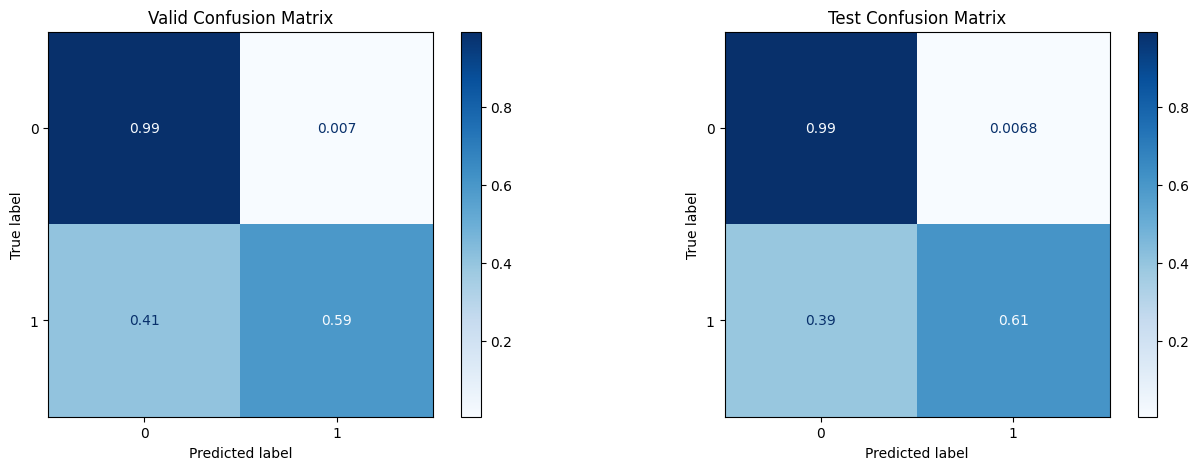

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
disp = ConfusionMatrixDisplay(confusion_matrix(valid[target], partial_viya.predict(valid[features]), normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[0])
axs[0].set_title('Valid Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test[target], final_viya.predict(test[features]), normalize='true'))
disp.plot(cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_title('Test Confusion Matrix')
plt.show()

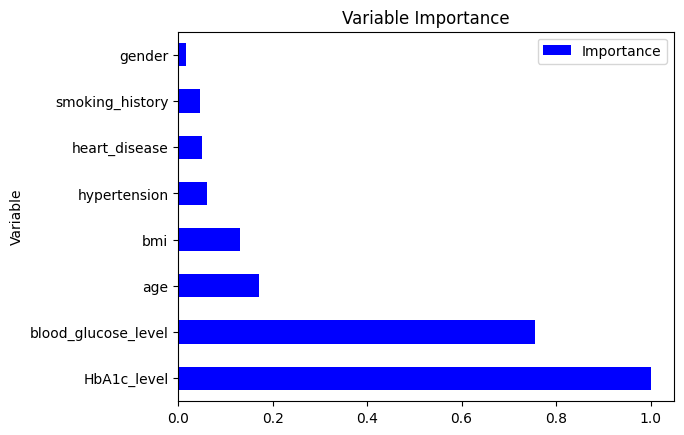

In [11]:
imps_viya = final_viya.feature_importances_
imps_viya['Importance']/=max(imps_viya['Importance'])

imps_viya.plot.barh(x='Variable', y='Importance', color='blue')
plt.title('Variable Importance')
plt.show()

In [12]:
test['Viya_Pred']=final_viya.predict(test[features])
test['P_diabetes1_Viya']=final_viya.predict_proba(test[features]).iloc[:,1]
test['P_diabetes0_Viya']=final_viya.predict_proba(test[features]).iloc[:,0]

train_valid['gender']=gender_encoder.inverse_transform(train_valid['gender'])
test['gender']=gender_encoder.inverse_transform(test['gender'])

train_valid['smoking_history']=smoking_history_encoder.inverse_transform(train_valid['smoking_history'])
test['smoking_history']=smoking_history_encoder.inverse_transform(test['smoking_history'])

newpath = '../output' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

test.to_csv(f'{newpath}/test_predictions.csv', index=False)
train_valid.to_csv(f'{newpath}/train_valid.csv', index=False)